- 启发来源：https://tianchi.aliyun.com/forum/postDetail?postId=99179

第一步：

观察数据后，能很明显的发现数据呈线性分布。

所以直接上Ridge回归，很尴尬的发现误差跑到了0.5…

将训练集和测试集对比后，删除了分布不均的特征，以及与target线性相关性弱的特征，误差降到了0.13.

将数据进行了: min-max归一化->偏态处理 ->precessing.scaler进行缩放(以平均值为中心,方差为单位)对数据进行处理后，
再次上Ridge回归，误差降到0.118.

看来，这次数据集的确大致是呈线性分布的，当然因为数据集本身很小，所以噪声对准确率的影响比较大。

In [1]:
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.max_open_warning': 0})
import seaborn as sns

# modelling
import pandas as pd
import numpy as np
import math

from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, RepeatedKFold, cross_val_score, cross_val_predict, KFold
from sklearn.metrics import make_scorer,mean_squared_error
from sklearn.linear_model import Lasso, Ridge
from sklearn.preprocessing import PolynomialFeatures, MinMaxScaler, StandardScaler, LabelEncoder, scale

#特征选择
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression

In [2]:
# 大小设置
sns.set(rc={'figure.figsize':(13,7)})
# 风格设置
sns.set_style("whitegrid")

goal = 'target'

# 数据导入

In [3]:
df_train = pd.read_table('../data/zhengqi_train.txt', sep='\t')
df_train.head(2)
df_test = pd.read_table('../data/zhengqi_test.txt', sep='\t')
df_test.head(2)
df_test["target"] = 0
df_train["isTrain"] = 1
df_test["isTrain"] = 0
dt = pd.concat([df_train, df_test], ignore_index=True)

# 去异常

In [113]:
# def del_outlies(dt=dt, sigma=3):
#     y = dt.loc[dt.isTrain==1, goal]
#     low_v = y.quantile(sigma/100)
#     up_v = y.quantile(1-sigma/100)
#     dt = dt[(dt.isTrain==0) | ((dt.isTrain==1) & (dt.target>=low_v) & (dt.target<=up_v))]   
#     return dt
# dt = del_outlies(dt=dt, sigma=3)

# 删除不一致特征

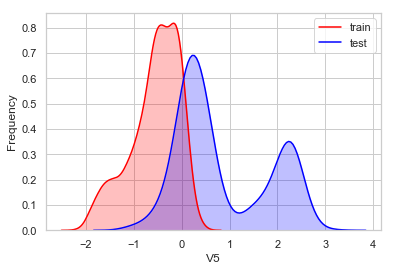

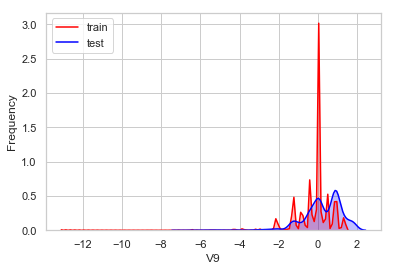

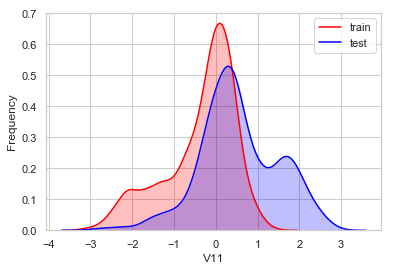

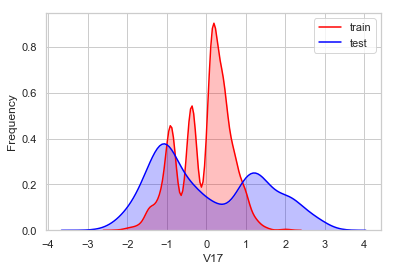

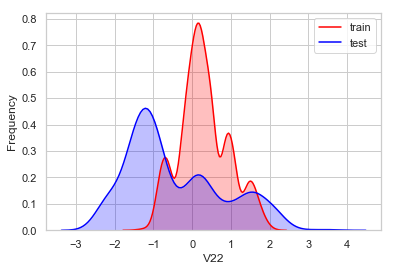

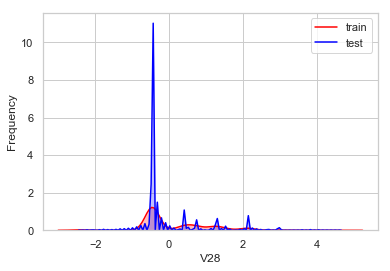

In [5]:
# wanping删除特征"V5","V9","V11","V17","V22","V28"，训练集和测试集分布不一致
for column in ["V5","V9","V11","V17","V22","V28"]:
    fig = plt.figure(figsize=(6, 4))
    g = sns.kdeplot(dt[column][(dt["isTrain"] == 1)], color="Red", shade = True)
    g = sns.kdeplot(dt[column][(dt["isTrain"] == 0)], ax =g, color="Blue", shade= True)
    g.set_xlabel(column)
    g.set_ylabel("Frequency")
    g = g.legend(["train","test"])
    plt.show()

dt.drop(["V5","V9","V11","V17","V22","V28"], axis=1, inplace=True)

# 删低相关

In [118]:
# print("=> 载入数据中...")
# train, test, features, category_feature = load_data()

=> 载入数据中...


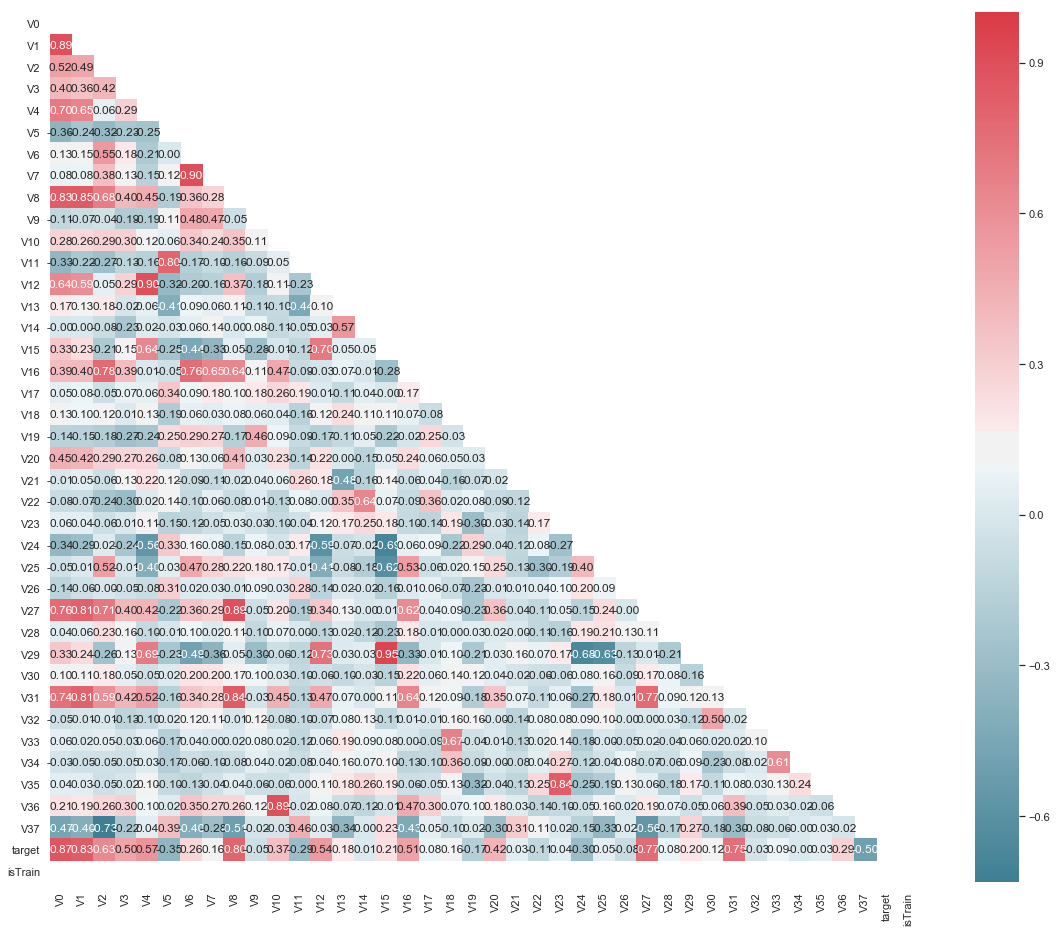

In [122]:
# # 找出相关程度
# plt.figure(figsize=(20, 16))  # 指定绘图对象宽度和高度
# colnm = train.columns.tolist()  # 列表头
# mcorr = train[colnm].corr(method="spearman")  # 相关系数矩阵，即给出了任意两个变量之间的相关系数
# mask = np.zeros_like(mcorr, dtype=np.bool)  # 构造与mcorr同维数矩阵 为bool型
# mask[np.triu_indices_from(mask)] = True  # 角分线右侧为True
# cmap = sns.diverging_palette(220, 10, as_cmap=True)  # 返回matplotlib colormap对象
# g = sns.heatmap(mcorr, mask=mask, cmap=cmap, square=True, annot=True, fmt='0.2f')  # 热力图（看两两相似度）
# plt.show()

In [123]:
# # Threshold for removing correlated variables
# threshold = 0.1

# # Absolute value correlation matrix
# corr_matrix = train.corr().abs()
# drop_col=corr_matrix[corr_matrix["target"]<threshold].index
# dt.drop(drop_col,axis=1,inplace=True)

# 数据min-max归一化

In [6]:
scaler = MinMaxScaler(feature_range=(0,1))
dt.iloc[:, 0:-2] = pd.DataFrame(scaler.fit_transform(dt.iloc[:, 0:-2]), columns=dt.columns[0:-2])

# 正态化

In [8]:
for col in ["V0", "V1", "V6", "V7", "V8", "V30"]:   
    dt[col] = dt[col].apply(lambda x:math.exp(x))

# 数据中心化缩放

In [9]:
dt.iloc[:, 0:-2] = pd.DataFrame(scale(dt.iloc[:, 0:-2]), columns = dt.columns[0:-2])

# 特征选择

In [10]:
noise_feature = [goal, 'isTrain']
features = [i for i in dt.columns if i not in noise_feature]

X_train = dt.loc[dt.isTrain==1, features]
y_train = dt.loc[dt.isTrain==1, goal]
X_test =  dt.loc[dt.isTrain==0, features]

In [11]:
#方差
threshold = 0.85
vt = VarianceThreshold().fit(X_train)

# Find feature names
feat_var_threshold = X_train.columns[vt.variances_ > threshold * (1-threshold)]
X_train = X_train[feat_var_threshold]
X_test = X_test[feat_var_threshold]
data = pd.concat([X_train, X_test])
print("方差后的shape", data.shape)

#单变量
X_scored = SelectKBest(score_func=f_regression, k='all').fit(X_train, y_train)
feature_scoring = pd.DataFrame({
        'feature': X_train.columns,
        'score': X_scored.scores_
    })

head_feature_num = 18
feat_scored_headnum = feature_scoring.sort_values('score', ascending=False).head(head_feature_num)['feature']
X_train_head = X_train[X_train.columns[X_train.columns.isin(feat_scored_headnum)]]
X_scaled = pd.DataFrame(scale(X_train), columns = X_train.columns)
X_test_head = X_test[X_test.columns[X_test.columns.isin(feat_scored_headnum)]]

print("单变量选择后的shape")
print(X_train_head.shape)
print(y_train.shape)
print(X_test_head.shape)

方差后的shape (4813, 31)
单变量选择后的shape
(2888, 18)
(2888,)
(1925, 18)


# 回归与分析

In [18]:
ridge = Ridge()
parameters = {"alpha": range(32, 40, 1)
             }
ridgeRegr = GridSearchCV(ridge, 
                         param_grid=parameters,
                         scoring='neg_mean_squared_error', 
                         n_jobs=4, 
                         verbose=1, 
                         cv=5)
evalute_result = ridgeRegr.fit(X_train_head, y_train)

print('每轮迭代运行结果:{0}'.format(evalute_result))
print('参数的最佳取值：{0}'.format(ridgeRegr.best_params_))
print('最佳模型得分:{0}'.format(ridgeRegr.best_score_))

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


每轮迭代运行结果:GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=None, normalize=False, random_state=None,
                             solver='auto', tol=0.001),
             iid='warn', n_jobs=4, param_grid={'alpha': range(32, 40)},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='neg_mean_squared_error', verbose=1)
参数的最佳取值：{'alpha': 37}
最佳模型得分:-0.1282148688739835


[Parallel(n_jobs=4)]: Done  40 out of  40 | elapsed:    3.8s finished


In [19]:
lastRidgeRegr = Ridge(alpha=37)
print('Ridge训练中...')
lastRidgeRegr.fit(X_train_head, y_train)

print('Ridge训练集预测中...')
train_target_pre = lastRidgeRegr.predict(X_train_head)

print('Ridge训练集MSE: ',mean_squared_error(y_true=y_train, y_pred=train_target_pre))

print('Ridge测试集预测中...')
test_target_pre = lastRidgeRegr.predict(X_test_head)

print('已完成')


Ridge训练中...
Ridge训练集预测中...
Ridge训练集MSE:  0.12062362812173409
Ridge测试集预测中...
已完成


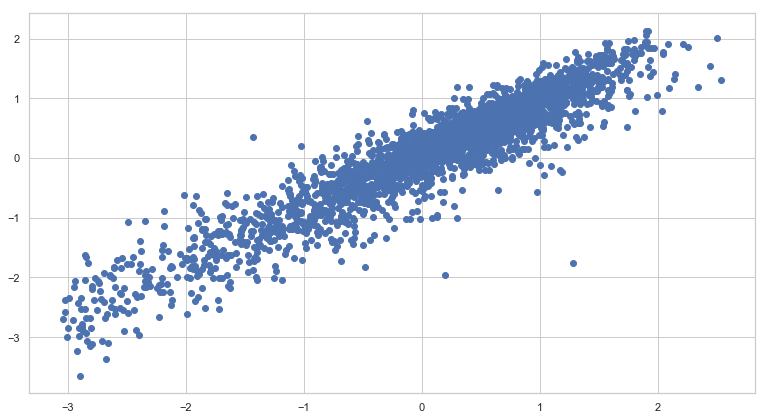

In [20]:
plt.scatter(y_train, train_target_pre)

# 保存结果

In [21]:
submission = pd.DataFrame({goal: test_target_pre})
submission.to_csv("../result/sample_submit09-xxxx-ridge.txt", sep='\t', index=False, header=False)